# PROYECTO 11 - ANALISIS BASADO EN EVENTOS

El proyecto se basará en el estudio de una empresa que vende productos alimenticios. El objetivo es investigar el comportamiento del usuario para la aplicación de la empresa.

### Paso 1. Abrir el archivo de datos y leer la información general

In [299]:
# Importación de librerías necesarias para trabajar:
import pandas as pd
import numpy as np 
import scipy as sp
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime as dt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go

In [300]:
#lectura e información del dataframe:

logs = pd.read_csv('logs_exp_us.csv', sep= '\s+', header=0,
                   dtype={'EventName':'category' , 'ExpId':'category'})

display(logs.head())
print("Cantidad de filas es: ", len(logs))
print("La estructura del dataset es: ", logs.shape)
print("Tipo de datos:")
logs.dtypes
print()
print("Información estadística del dataset:")
logs.info(memory_usage="deep")

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Cantidad de filas es:  244126
La estructura del dataset es:  (244126, 4)
Tipo de datos:

Información estadística del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   EventName       244126 non-null  category
 1   DeviceIDHash    244126 non-null  int64   
 2   EventTimestamp  244126 non-null  int64   
 3   ExpId           244126 non-null  category
dtypes: category(2), int64(2)
memory usage: 4.2 MB


A primera instancia con este DF logs, obtenemos que esta compuesto por cuatro columnas con nombres que no están bien definidos para seguir o continuar una praxis correcta. Por otro lado, podemos apreciar que el conteo de los no nulos por la información del dataset sería de cero. Finalmente, cada entrada de registro es una acción de usuario o un evento.
+ EventName: nombre del evento.
+ DeviceIDHash: identificador de usuario unívoco.
+ EventTimestamp: hora del evento - Figura como entero, se procederá con el cambio a datetime.
+ ExpId: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

### Paso 2. Preparar los datos para el análisis

####  2.1 Cambia el nombre de las columnas y comprueba si hay tipos de datos y valores ausentes.

In [301]:
logs.columns = ['event_name', 'user_id', 'event_date', 'experiment_id']
logs.head()

,event_name,user_id,event_date,experiment_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### 2.2	Comprueba si hay tipos de datos duplicados, por cambiar de tipo y valores ausentes. Corrige los datos si es necesario

In [302]:
#Modificar a datime event_date:

logs['event_date'] = logs['event_date'].apply(lambda x: pd.to_datetime(x, unit='s'))

logs.head()

,event_name,user_id,event_date,experiment_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [303]:
# Verificar datos duplicados o nulos:

logs.isna().sum()

event_name       0
user_id          0
event_date       0
experiment_id    0
dtype: int64

In [304]:
logs[logs.duplicated()]


,event_name,user_id,event_date,experiment_id
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,247
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,247
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,246
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,246


In [305]:
# Se procede con la eliminación de duplicados. Se decide esto ya que los 413 registros no representan ni el 0.16% de la data, por lo que no generaría
# inconvenientes proceder.
logs.drop_duplicates(inplace=True)

logs.reset_index(inplace=True, drop=True)


### 2.3 Agrega una columna de fecha y hora y una columna separada para las fechas

In [306]:
logs['date'] = logs['event_date'].dt.date
logs['hour'] = logs['event_date'].dt.time
logs

,event_name,user_id,event_date,experiment_id,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07,21:12:25
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07,21:13:59
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07,21:14:43
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07,21:14:58


### Paso 3: Estudiar y comprobar los datos

#### 3.1 ¿Cuántos eventos hay en los registros?

In [307]:

logs['event_name'].unique()

['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial']
Categories (5, object): ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

Se obtiene una totalidad de 05 eventos o categorías dentro de nuestro DF.

#### 3.2 ¿Cuántos usuarios y usuarias hay en los registros?

In [308]:
# En total hay registrados 7551 usuarios / usuarias y 05 eventos.
logs.nunique()

event_name            5
user_id            7551
event_date       176654
experiment_id         3
date                 14
hour              69824
dtype: int64

In [309]:
logs.groupby('event_name')['user_id'].count()

C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\1821341639.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



event_name
CartScreenAppear            42668
MainScreenAppear           119101
OffersScreenAppear          46808
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: user_id, dtype: int64

#### 3.3 ¿Cuál es el promedio de eventos por usuario?

In [310]:
prom = logs.groupby('user_id').agg({'event_name' : 'count'})
prom_user = prom['event_name'].mean()
prom_user

#Se obtiene que el promedio de eventos por usuario es de 32.

32.27559263673685

### 3.4 ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. 

In [311]:
#Hallemos la fecha inicial y final del proyecto:
min = logs['date'].min()
max = logs['date'].max()
print('El experimento ha iniciado en' , min, 'y ha culminado el' , max)
print()
print('La duración del proyecto ha sido de' , max - min)

El experimento ha iniciado en 2019-07-25 y ha culminado el 2019-08-07

La duración del proyecto ha sido de 13 days, 0:00:00


#### 3.4.1 Traza un histograma por fecha y hora. 

<Axes: >

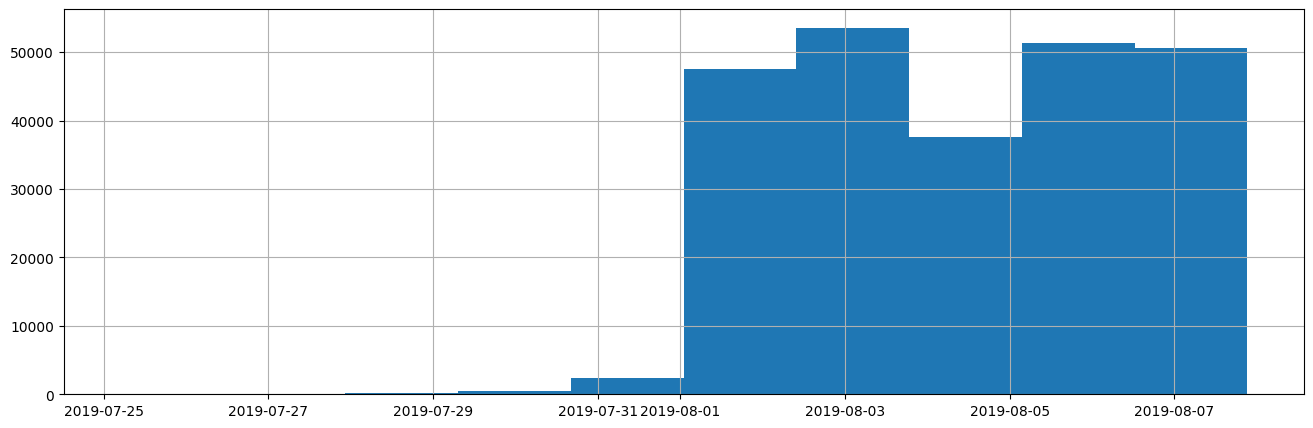

In [312]:
# Histograma por hora y fecha:

logs['event_date'].hist(figsize = [16,5])

Este histograma nos permite conocer las fechas donde se cuenta con mayor frecuencia que se ha realizado el experimento, el rango sería desde el 31/07 al 07/08.

#### 3.4.2 ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

<Axes: title={'center': 'Relación histórica de usuarios por fecha'}, xlabel='date'>

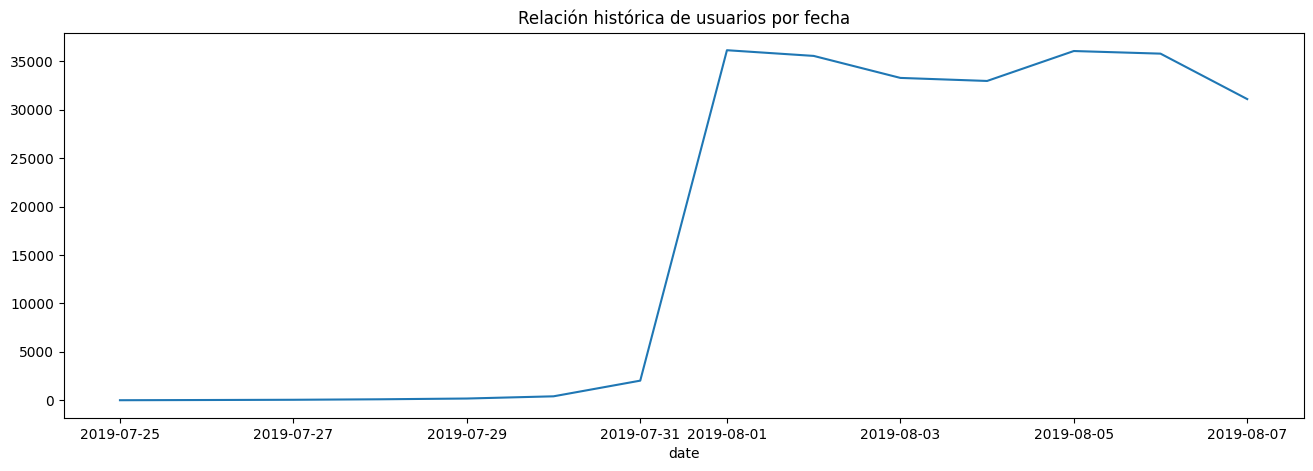

In [313]:
# Procedemos a agrupar y contar por usuario, de esta manera obtendremos el histórico de estos a través del tiempo.
data = logs.groupby('date')['user_id'].count()
data.plot(figsize = [16,5], title='Relación histórica de usuarios por fecha')

In [314]:
#Aplicamos un filtro en el quiebre positivo para evaluar si se afectan nuestros datos. Pero considerando el comportamiento del 
# histograma obtenido en la parte anterior, no debería perjudicar ya que la mayoría de datos estaría concentrada a partir del filtro a continuación:
data_filter = logs[logs['date'] > pd.to_datetime('2019-07-31').date()]
data.filter

<bound method NDFrame.filter of date
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      412
2019-07-31     2030
2019-08-01    36141
2019-08-02    35554
2019-08-03    33282
2019-08-04    32968
2019-08-05    36058
2019-08-06    35788
2019-08-07    31096
Name: user_id, dtype: int64>

In [315]:
# Calculamos la fecha mínima y máxima para comprender que está dentro del rango del filtro:

print('La fecha mínima es:',  data_filter['date'].min())

print()

print('La fecha mínima es:',  data_filter['date'].max())


La fecha mínima es: 2019-08-01

La fecha mínima es: 2019-08-07


Se puede visualizar a primera instancia que hay un quiebre positivo para la empresa a partir del 31/07/2019, que es donde crece exponencialmente hasta aproximadamente 35,000. Posterior a esta etapa, tiene un comportamiento relativamente constante.
En el cálculo de fechas, se puede confirmar que el filtro realizado de usuarios y eventos se encuentra dentro del rango de tiempo que se ha realizado el estudio.

#### 3.5 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [316]:
# Vamos a analizar la proporción del filtro respecto a la data original para realizar la evaluación de pérdida porcentual de usuarios:

prop_user = ((data_filter['user_id'].nunique() / logs['user_id'].nunique() ) * 100)

print('El porcentaje de usuarios participantes luego de realizar el filtro es de: ', prop_user,'%')

El porcentaje de usuarios participantes luego de realizar el filtro es de:  99.77486425638989 %


Al analizar con respecto a usuarios, obtenemos que contamos aún luego de aplicar el filtro con un 99.77%, por lo que no se ha perdido una cantidad que interfiera con la continuidad del experimento.

In [317]:
# Vamos a analizar la proporción del filtro respecto a la data original para realizar la evaluación de pérdida porcentual de eventos:

prop_event = ((data_filter['event_name'].nunique() / logs['event_name'].nunique() ) * 100)

print('El porcentaje de eventos luego de realizar el filtro es de: ', prop_event,'%')

El porcentaje de eventos luego de realizar el filtro es de:  100.0 %


Se cuenta con el 100% de la participación de los eventos en el experimento.

In [318]:
# Vamos a analizar la proporción del filtro respecto a la data original para realizar la evaluación de pérdida porcentual de registros:

prop_regist = (data_filter.shape[0] / logs.shape[0]) * 100

print('El porcentaje de registros despúes de realizar el filtro es de:', prop_regist,'%')

El porcentaje de registros despúes de realizar el filtro es de: 98.8404393692581 %


Se cuenta con una participación de registros del 98.84%. Por lo que se puede responder a la pregunta que no nos hemos visto afectados en ningún campo significativo para continuar con el expermiento.

#### 3.6 Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [319]:
data_filter.groupby('experiment_id')['user_id'].nunique()

C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\740678107.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



experiment_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

Se puede revisar que contamos con usuarios contados en cada uno de los 03 experimentos que estamos realizando. Además, que están repartidos practicamente de manera equitativa en cada uno.

### Paso 4: Estudiar el embudo de eventos

#### 4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [320]:
# Agrupamos y contamos los usuarios por cada uno de los eventos para revisar su frecuencia:

reg_frec = data_filter.groupby('event_name')['user_id'].count().sort_values(ascending=False)
reg_frec

C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\4234102582.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: user_id, dtype: int64

<Axes: >

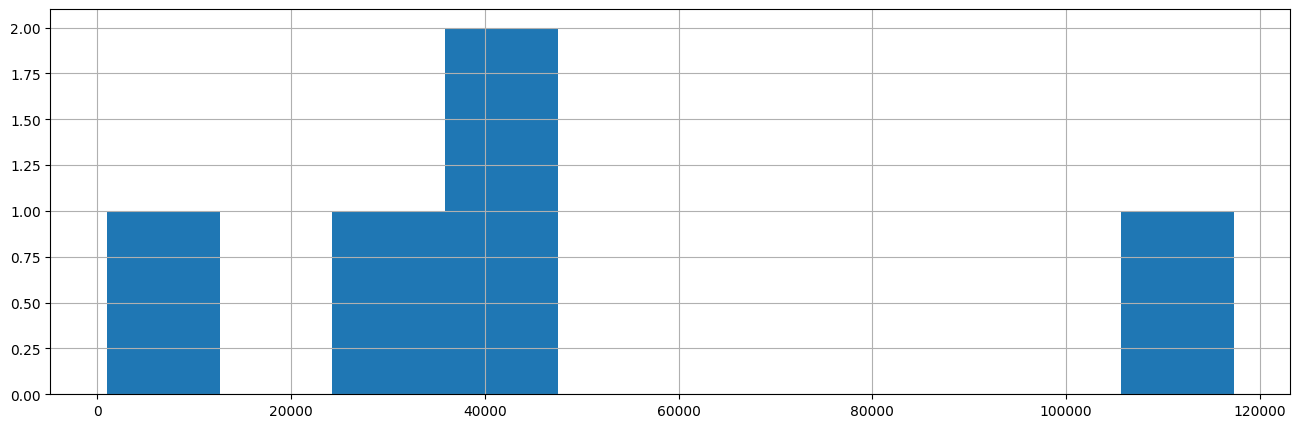

In [321]:
reg_frec.hist(figsize=[16,5])

#### 4.2 Encuentra la cantidad de usuarios  que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. 

In [322]:
# Agrupamos y contamos los usuarios ÚNICOS por cada uno de los eventos para revisar su frecuencia: 

reg_frec_uniq = data_filter.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
reg_frec_uniq

C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\1898471706.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

<Axes: >

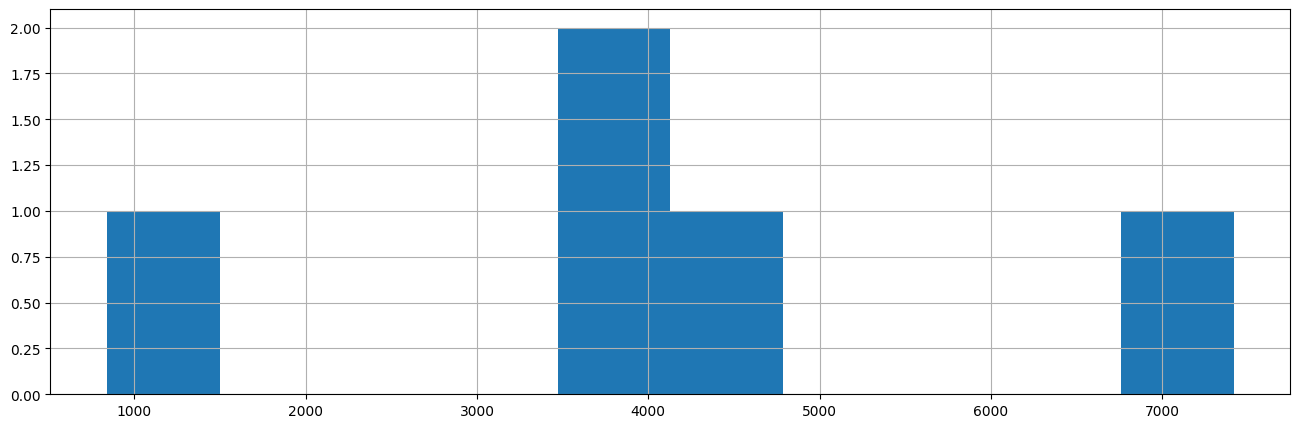

In [323]:
# Graficamos histograma de frecuencia para los usuarios únicos que participaron en los 5 eventos:
reg_frec_uniq.hist(figsize=[16,5])

#### 4.2.1 Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [324]:
proportion = data_filter.drop(['experiment_id', 'date', 'hour', 'event_date'], axis=1)
prop_1 = proportion.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()

prop_1['at_least_one'] = (prop_1['user_id'] / 19285) * 100 

prop_1



C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\2481661490.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,event_name,user_id,at_least_one
0,MainScreenAppear,7419,38.470314
1,OffersScreenAppear,4593,23.816438
2,CartScreenAppear,3734,19.362199
3,PaymentScreenSuccessful,3539,18.351050
4,Tutorial,840,4.355717


Se obtiene los porcentajes de participación de cada uno de los eventos considerando usuarios únicos. Según el orden ascendente, el mayor sería la parte inicial que se considera MainScreenAppear, que es donde la mayoría de usuarios inician su interacción.

#### 4.3 ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

El orden de los sucesos de los eventos es que el usuario ingresa a la pantalla principal, aparece la oferta del producto, se dirige al apartado del carrito de compras, finalmente se visualiza el pago exitoso. En el caso del tutorial, se consideraría como un evento externo (no entraría a ser parte de la secuencia) porque no participa dentro del flujo evaluado. Por lo que sería el siguiente:

1. MainScreenAppear           
2. OffersScreenAppear         
3. CartScreenAppear           
4. PaymentScreenSuccessful    

#### 4.4 Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. 


In [325]:
# Creamos un DF que esté filtrado por los usuarios únicos y los eventos.
funnel = data_filter.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
funnel['previous_event']      = funnel['user_id'].shift(1)
funnel['prop_previous_event'] = funnel['user_id'] / funnel['previous_event']
funnel['dropoff_rate']        = 1 - funnel['prop_previous_event']

funnel



C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\376728294.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,event_name,user_id,previous_event,prop_previous_event,dropoff_rate
0,MainScreenAppear,7419,NaN,NaN,NaN
1,OffersScreenAppear,4593,7419.0,0.619086,0.380914
2,CartScreenAppear,3734,4593.0,0.812976,0.187024
3,PaymentScreenSuccessful,3539,3734.0,0.947777,0.052223
4,Tutorial,840,3539.0,0.237355,0.762645


In [326]:
data = dict(
    number=[0,0.619086, 0.812976, 0.947777, 0.237355],
    stage=["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful", "Tutorial"])
fig = px.funnel(data, x='number', y='stage')
fig.show()

In [327]:
fig = go.Figure(go.Funnel(
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [7419, 4593, 3734, 3539],
    textinfo = 'value+percent initial'
))
fig.update_traces(marker = {'line': {'width': [1, 1, 1, 3], 'color': ['gray', 'gray', 'gray', 'red']}})
fig.show()

#### 4.5 ¿En qué etapa pierdes más usuarios?

Se pierden la mayor cantidad de usuarios en la útlima etapa que es la del pago. Corresponden a un 47.7% respecto al total que inicia el proceso del experimento.

#### 4.6 ¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

Ese porcentaje corresponde a 18.4% respecto al total que iniciaron el primer evento.

### Paso 5: Estudiar los resultados del experimento

#### 5.1 ¿Cuántos usuarios y usuarias hay en cada grupo?

In [328]:
#Se realiza un agrupamiento de experimentos y conteo por usuario.
data_filter.groupby('experiment_id')['user_id'].nunique().sort_values(ascending=False)

C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\2886057656.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



experiment_id
248    2537
247    2513
246    2484
Name: user_id, dtype: int64

#### 5.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [329]:
# Creamos un DF donde tengamos experiment_id y user_id, y adicional una columna que pueda permitirnos conocer si ese usuario llegó 
# a la recta final PaymentScreenSuccessful que lo llamaremos control:

control = data_filter[['user_id', 'experiment_id']].drop_duplicates()
control.head()

,user_id,experiment_id
2826,3737462046622621720,246
2830,1433840883824088890,247
2831,4899590676214355127,247
2838,1182179323890311443,246
2842,4613461174774205834,248


In [330]:
#Creamos un nuevo DF para adicionarlo a control, con la finalidad de encontrar en la nueva columna todos los usuarios que 
# convirtieron la compra (columna converted), si es 1 es que procedieron.
control_1 = pd.DataFrame (data = { 
    'user_id' : data_filter[data_filter['event_name'] == 'PaymentScreenSuccessful']['user_id'].unique(),
    'converted' : 1 })

control_1

,user_id,converted
0,4613461174774205834,1
1,2712290788139738557,1
2,6049698452889664846,1
3,5653442602434498252,1
4,6126676435667432321,1
...,...,...
3534,4369662623769092250,1
3535,4876403292056911122,1
3536,1309234519709630135,1
3537,7823752606740475984,1


In [331]:
# Utilizamos el método merge para unir la columna converted:
control_merge = control.merge(control_1,on='user_id', how= 'left')
control_merge['converted'] = control_merge['converted'].fillna(0)
control_merge

,user_id,experiment_id,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0
...,...,...,...
7529,5811573131275421338,248,0.0
7530,5365227480683749189,248,0.0
7531,6660805781687343085,246,0.0
7532,7823752606740475984,246,1.0


In [332]:
# Analizar si tienen diferencia significativa, creamos una variable para cada grupo:

group_246 = control_merge[control_merge['experiment_id'] == '246']['converted'] 

group_247 = control_merge[control_merge['experiment_id'] == '247']['converted']

Procedemos a crear nuestras hipótesis según encabezado de la consulta si existe diferencia significativa entre ambos grupos:

Ho = La tasa promedio de usuarios que llegan al punto de control entre los grupos 246 y 247 son iguales.

H1 = La tasa promedio de usuarios que llegan al punto de control entre los grupos 246 y 247 son distintas.


In [333]:
# Definimos alpha

alpha = 0.1

results = st.ttest_ind(group_246, group_247)

print("El valor de p: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No podemos rechazar la hipótesis nula")

El valor de p:  0.1146123316324848
No podemos rechazar la hipótesis nula


Se llega a la conclusión que la tasa promedio de usuarios que llegan al punto de control entre ambos grupos en mención son iguales, ya que obtenemos que no se puede rechazar la Ho. No existe diferencia significativa.

### 5.3 Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. 

El evento que se considera más popular es el de MainScreenAppear que contiene la mayor parte de participación por parte de los usuarios. Pero el que yo considero es el más importante es el de PaymentScreenSuccessful porque es aquel que genera un ingreso para la empresa.

In [334]:
# Cantidad de usuarios únicos que realizaron cada uno de los grupos de control.
user_per_group = data_filter.groupby('experiment_id')['user_id'].nunique().sort_values(ascending=False).reset_index()
user_per_group

C:\Users\Alfredo OG\AppData\Local\Temp\ipykernel_18408\1712279909.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,experiment_id,user_id
0,248,2537
1,247,2513
2,246,2484


In [335]:
user_per_group['proportion_per_user'] = user_per_group['user_id'] / (2537+2513+2484)
user_per_group

,experiment_id,user_id,proportion_per_user
0,248,2537,0.336740
1,247,2513,0.333555
2,246,2484,0.329705


Se obtiene las proporciones de cada uno de los grupos, siendo el 248 el que cuenta con relativamente un mayor porcentaje.

#### 5.3.1 Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

In [336]:
#Creamos un nuevo DF para adicionarlo a control df base, con la finalidad de encontrar en la nueva columna todos los usuarios que 
# convirtieron la parte del proceso especificada a continuación y generar la columna converted con valores 1 y 0

# MainScreenAppear

control_2 = pd.DataFrame (data = { 
    'user_id' : data_filter[data_filter['event_name'] == 'MainScreenAppear']['user_id'].unique(),
    'converted' : 1 })

# Utilizamos el método merge para unir los df:
control_main = control.merge(control_2,on='user_id', how= 'left')
control_main['converted'] = control_main['converted'].fillna(0)

# Analizar si tienen diferencia significativa, creamos una variable para cada grupo:

group_main_246 = control_main[control_main['experiment_id'] == '246']['converted'] 
group_main_247 = control_main[control_main['experiment_id'] == '247']['converted']

# Procedemos con el análisis con la prueba ttest:

results = st.ttest_ind(group_main_246, group_main_247)

print("El valor de p: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No podemos rechazar la hipótesis nula")

El valor de p:  0.7571174621103072
No podemos rechazar la hipótesis nula


In [337]:
#Creamos un nuevo DF para adicionarlo a control df base, con la finalidad de encontrar en la nueva columna todos los usuarios que 
# convirtieron la parte del proceso especificada a continuación y generar la columna converted con valores 1 y 0

# CartScreenAppear

control_3 = pd.DataFrame (data = { 
    'user_id' : data_filter[data_filter['event_name'] == 'CartScreenAppear']['user_id'].unique(),
    'converted' : 1 })

# Utilizamos el método merge para unir los df:
control_cart = control.merge(control_3,on='user_id', how= 'left')
control_cart['converted'] = control_cart['converted'].fillna(0)

# Analizar si tienen diferencia significativa, creamos una variable para cada grupo:

group_cart_246 = control_cart[control_cart['experiment_id'] == '246']['converted'] 
group_cart_247 = control_cart[control_cart['experiment_id'] == '247']['converted']

# Procedemos con el análisis con la prueba ttest:

results = st.ttest_ind(group_cart_246, group_cart_247)

print("El valor de p: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No podemos rechazar la hipótesis nula")

El valor de p:  0.22891646330485427
No podemos rechazar la hipótesis nula


In [338]:
#Creamos un nuevo DF para adicionarlo a control df base, con la finalidad de encontrar en la nueva columna todos los usuarios que 
# convirtieron la parte del proceso especificada a continuación y generar la columna converted con valores 1 y 0

# OffersScreenAppear

control_4 = pd.DataFrame (data = { 
    'user_id' : data_filter[data_filter['event_name'] == 'OffersScreenAppear']['user_id'].unique(),
    'converted' : 1 })

# Utilizamos el método merge para unir los df:
control_offer = control.merge(control_4,on='user_id', how= 'left')
control_offer['converted'] = control_cart['converted'].fillna(0)

# Analizar si tienen diferencia significativa, creamos una variable para cada grupo:

group_offer_246 = control_offer[control_offer['experiment_id'] == '246']['converted'] 
group_offer_247 = control_offer[control_offer['experiment_id'] == '247']['converted']

# Procedemos con el análisis con la prueba ttest:

results = st.ttest_ind(group_offer_246, group_offer_247)

print("El valor de p: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No podemos rechazar la hipótesis nula")

El valor de p:  0.22891646330485427
No podemos rechazar la hipótesis nula


Se ha realizado el análisis por cada uno de los eventos para los grupos A/A y se ha obtenido que no se puede rechazar la hipótesis nula, lo que quiere indicar que la tasa promedio de usuarios que llegan al punto de control entre los grupos 246 y 247 son iguales. Es decir, que los eventos y los grupos están conformes.

#### 5.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

Vamos a comparar tres escenarios: 

+ GRUPO 248 - GRUPO 247 
+ GRUPO 248 - GRUPO 246
+ GRUPO 248 - GRUPO 247 + GRUPO 246

In [339]:
# Creamos los grupos 248 y uno referente al control:

group_248 = control_merge[control_merge['experiment_id'] == '248']['converted'] 
group_control = control_merge[~(control_merge['experiment_id'] == '248')]['converted']

# Procedemos con el análisis con la prueba ttest: 

results = st.ttest_ind(group_248, group_247)

print("El valor de p: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No podemos rechazar la hipótesis nula")

El valor de p:  0.7374027184332623
No podemos rechazar la hipótesis nula


In [340]:
# Procedemos con el análisis con la prueba ttest: 

results = st.ttest_ind(group_248, group_246)

print("El valor de p: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No podemos rechazar la hipótesis nula")

El valor de p:  0.2123337471133262
No podemos rechazar la hipótesis nula


In [341]:
# Procedemos con el análisis con la prueba ttest: 

results = st.ttest_ind(group_248, group_control)

print("El valor de p: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else: 
    print("No podemos rechazar la hipótesis nula")

El valor de p:  0.600486568376488
No podemos rechazar la hipótesis nula


Cuando utilizamos las fuentes alteradas se mantienen la disposición de aceptación de las hipótesis nulas. Se procede a confirmar que al no rechazo de estas, los grupos son iguales.

#### 5.5 ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

In [342]:
n_test = 12 
print('La probabilidad de que suceda un falso positivo es de: ', (1 - (1-alpha)**n_test))

La probabilidad de que suceda un falso positivo es de:  0.7175704635189999


In [344]:
# Aplicamos el criterio de una significancia menor para poder eliminar los falsos positivos en nuestro experimento:
n_pruebas = 12
significancia = 0.05

print("la probabilidad de un falso positivo es de: ", (1 - (1-significancia)**n_pruebas))

la probabilidad de un falso positivo es de:  0.45963991233736334


In [345]:
n_pruebas = 12
significancia = 0.01

print("la probabilidad de un falso positivo es de: ", (1 - (1-significancia)**n_pruebas))

la probabilidad de un falso positivo es de:  0.11361512828387077
